In [2]:
from mp_api.client import MPRester
import numpy as np
import pandas as pd
API_KEY = "4IeHY5jVcrgiKXNuAo6Jgs7yC0Z3hsli"
try:
    with MPRester(API_KEY) as mpr:
        # Query for Li-based cathode materials with high energy density
        docs = mpr.materials.insertion_electrodes.search(
        average_voltage = (2.5, 10.0), stability_charge=(0.0, 0.90), energy_grav=(350, 2000), capacity_grav=(100, 2000), max_delta_volume=(0.0, 0.050),
        fields=[
            "battery_id", "formula_discharge", "average_voltage"
            , "energy_grav", "energy_vol", "capacity_grav", "capacity_vol", "stability_charge", "fracA_charge", "max_delta_volume", "stability_discharge", "fracA_discharge"
        ])

        Fields = "average_voltage", "energy_grav", "energy_vol", "capacity_grav", "capacity_vol", "max_delta_volume", "stability_charge", "stability_discharge", "fracA_charge", "fracA_discharge"

        def average_field(docs, field):
            vals = [getattr(d, field) for d in docs if getattr(d, field) is not None]
            return sum(vals) / len(vals)


        df = pd.DataFrame([doc.dict() for doc in docs])
        df.head(20)

        for f in Fields:
            avg = average_field(docs, f)
            print(f"{f}: {avg}")
        print(len(df))
        df.head(20)


except Exception as e:
    print(f"An error occurred: {e}")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Retrieving InsertionElectrodeDoc documents: 100%|██████████| 1109/1109 [00:00<00:00, 6974.05it/s]

average_voltage: 3.858550704781007
energy_grav: 609.8066769368519
energy_vol: 2184.429156922501
capacity_grav: 159.98305658126108
capacity_vol: 579.348764131581
max_delta_volume: 0.02386193916642448
stability_charge: 0.10788860290552464
stability_discharge: 0.049938070329117644
fracA_charge: 0.046734236546902105
fracA_discharge: 0.16044573036266302
1109


In [4]:
from sklearn.cluster import KMeans
features = df[[
    "average_voltage",
    "capacity_grav",
    "max_delta_volume",
    "fracA_charge"
]].dropna()

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(features)

from sklearn.decomposition import PCA
import pandas as pd

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

loadings = pd.DataFrame(
    pca.components_.T,
    columns=["PC1", "PC2"],
    index=features.columns
)

print(loadings)


kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(X)

df["cluster"] = labels

df.groupby("cluster")[[
    "average_voltage",
    "capacity_grav",
    "max_delta_volume",
    "fracA_charge"
]].mean()

                       PC1       PC2
average_voltage   0.704372 -0.077939
capacity_grav    -0.423493  0.614416
max_delta_volume  0.156985  0.688046
fracA_charge     -0.547603 -0.378168


,average_voltage,capacity_grav,max_delta_volume,fracA_charge
cluster,,,,
0,4.039730,142.863636,0.037207,0.014855
1,3.494437,257.322936,0.027570,0.023697
2,4.027737,139.931676,0.011755,0.013225
3,3.493776,155.277731,0.018819,0.182059


In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0)
labels = kmeans.fit_predict(X)

df["cluster"] = labels

df.groupby("cluster")[[
    "average_voltage",
    "capacity_grav",
    "max_delta_volume",
    "fracA_charge"
]].mean()


In [ ]:
%%sql


In [7]:
import statsmodels.api as sm

X_reg = df[["capacity_grav", "average_voltage", "max_delta_volume"]]
X_reg = sm.add_constant(X_reg)

y = df["fracA_charge"]

model = sm.OLS(y, X_reg).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           fracA_charge   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     16.58
Date:                Thu, 19 Feb 2026   Prob (F-statistic):           1.53e-10
Time:                        15:34:47   Log-Likelihood:                 1237.7
No. Observations:                1109   AIC:                            -2467.
Df Residuals:                    1105   BIC:                            -2447.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1412      0.016  

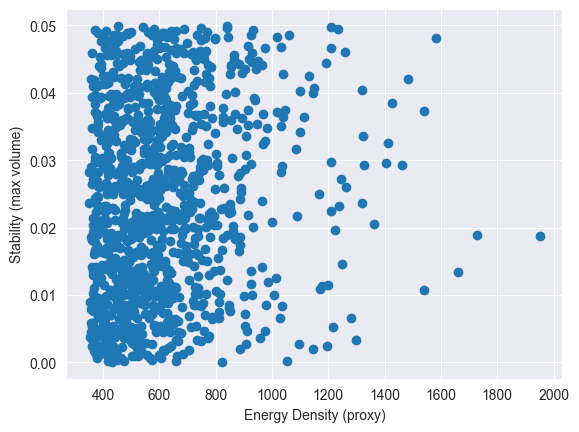

In [8]:
import matplotlib.pyplot as plt

plt.scatter(df["capacity_grav"] * df["average_voltage"],
            df["max_delta_volume"])

plt.xlabel("Energy Density (proxy)")
plt.ylabel("Stability (max volume)")
plt.show()

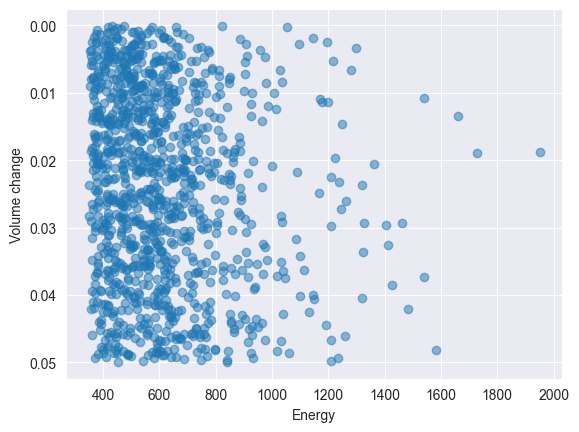

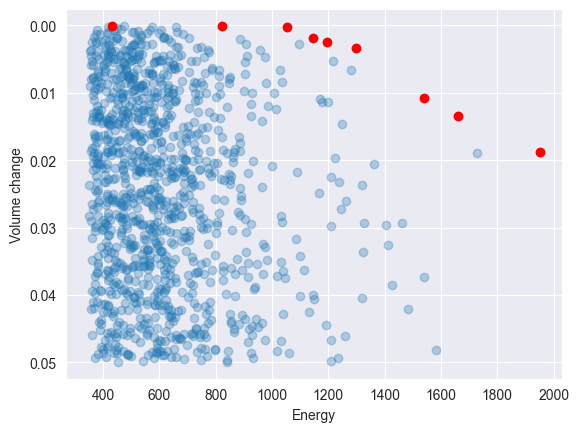

In [10]:
df["energy"] = df["capacity_grav"] * df["average_voltage"]

import matplotlib.pyplot as plt

plt.scatter(df["energy"], df["max_delta_volume"], alpha=0.5)
plt.xlabel("Energy")
plt.ylabel("Volume change")
plt.gca().invert_yaxis()  # lower instability appears higher
plt.show()

import numpy as np

def pareto_front(df):
    pareto = []
    for i, row in df.iterrows():
        dominated = False
        for j, other in df.iterrows():
            if (
                other["energy"] >= row["energy"] and
                other["max_delta_volume"] <= row["max_delta_volume"] and
                (
                    other["energy"] > row["energy"] or
                    other["max_delta_volume"] < row["max_delta_volume"]
                )
            ):
                dominated = True
                break
        if not dominated:
            pareto.append(i)
    return df.loc[pareto]

pareto_df = pareto_front(df)

plt.scatter(df["energy"], df["max_delta_volume"], alpha=0.3)
plt.scatter(pareto_df["energy"], pareto_df["max_delta_volume"], color="red")
plt.xlabel("Energy")
plt.ylabel("Volume change")
plt.gca().invert_yaxis()
plt.show()